# CAFEPP (utilising cafepp.py)

***

## This example will produce a set of monthly SST files across the V1 assimilation run (interpolated onto a 1x1 latxlon grid), and upon success, generate an average over the nino3.4 region and plot the time-series.

***

# Various settings required:

## BATCH determines whether it will be sent to the queue via qsub command or run interactively.

## CLEAN determines whether the run directory will be emptied prior to processing.

In [50]:
print('BEGIN')

from __future__ import print_function #this is to allow print(,file=xxx) feature

import datetime
import shutil
import os

dvar='tos' #variable to generate as well as further proces and plot.

BATCH=True #submit to queue
BATCH=False #run interactively but in a batch temporary area.

CLEAN=False #don't remove rundir, just use it.
CLEAN=True #remove rundir and recreate it.

if(BATCH):
  print('Submitting to queue.')

if(CLEAN):
  print('Removing run directory and reestablish it.')

cmipdir='/short/v14/mac599' #this might be different to predir for other users.
predir='/short/v14/mac599' #this is directory area for temporary cafepp files.
topdir=predir+'/'+'cafepp'
script='cafepp_monthly_assimilation.py'

rundir=topdir+'/'+'rundir20171124143249'
rundir=topdir+'/'+'rundir20171128165302'
rundir=topdir+'/'+'rundir'+datetime.datetime.today().strftime('%Y%m%d%H%M%S')
rundir=topdir+'/'+'rundir' #temporary running directory

print('Running in directory '+rundir)
print('Using script '+script)

srcdir='/home/599/mac599/decadal' #location of main cafepp code
prodir=srcdir+'/paper_analysis' #project directory

print('END')

BEGIN
Removing run directory and reestablish it.
Running in directory /short/v14/mac599/cafepp/rundir
Using script cafepp_monthly_assimilation.py
END


# Here we make directories, copy across necessary JSON and python code.

In [51]:
print('BEGIN')

print('copying json files, generating symlinks, cmor tables, queue script, if necessary.')
if(os.path.exists(rundir) and CLEAN):
  shutil.rmtree(rundir)
  os.mkdir(rundir)
  os.mkdir(rundir+'/'+'JsonTemplates') # exist_ok=True only python3
elif(not os.path.exists(rundir)):
  os.mkdir(rundir)
  os.mkdir(rundir+'/'+'JsonTemplates') # exist_ok=True only python3

if(os.path.isdir(cmipdir+'/'+'CMIP6')):
  print('hello')
  os.symlink(cmipdir+'/'+'CMIP6',rundir+'/'+'CMIP6')
else:
  print('there')
  os.mkdir(cmipdir)
os.symlink(prodir+'/'+'TablesTemplates',rundir+'/'+'TablesTemplates')
os.symlink(prodir+'/'+'cmip6-cmor-tables',rundir+'/'+'cmip6-cmor-tables')

if(BATCH): #temporary
  print('Copying and editing '+prodir+'/'+'qjob.csh to '+rundir+'/'+'qjob.csh')
  ifh=open(prodir+'/'+'qjob.csh')
  ofh=open(rundir+'/'+'qjob.csh','w')
  for i,line in enumerate(ifh):
    line=line.replace('CAFEPP_SCRIPT','./'+script+' RUNDIR')
    line=line.replace('RUNDIR',rundir)
    line=line.replace('CONDA_SOURCE','. /short/v14/mac599/anaconda3/etc/profile.d/conda.sh')
    line=line.replace('CONDA_ACTIVATE','conda activate cafepp_27_scipy')
    print(line,file=ofh,end='')
  ifh.close()
  ofh.close()

vector_string=['decadal_diag.py','cafepp.py','app_funcs.py']
for i,file_now in enumerate(vector_string):
  print('Copying '+srcdir+'/'+file_now+' to ',rundir)
  shutil.copyfile(srcdir+'/'+file_now,rundir+'/'+file_now)

vector_string=[script]
for i,file_now in enumerate(vector_string):
  print('Copying '+prodir+'/'+file_now+' to ',rundir)
  shutil.copyfile(prodir+'/'+file_now,rundir+'/'+file_now)
  
vector_string=[]
vector_string.append(script) #may need to do edits?
vector_string.append('cafepp_monthly_assimilation.json')
vector_string.append('cafepp_daily_forecast_experiments.json')
vector_string.append('JsonTemplates'+'/'+'cafepp_csiro-gfdl.json')
vector_string.append('JsonTemplates'+'/'+'cafepp_vars.json')

for i,file_now in enumerate(vector_string):
  print('Copying '+prodir+'/'+file_now+' to ',rundir)
  shutil.copyfile(prodir+'/'+file_now,rundir+'/'+file_now)
  
print('Processing cafepp_monthly_assimilation.json')
ifh=open(prodir+'/'+'cafepp_monthly_assimilation.json')
ofh=open(rundir+'/'+'cafepp_monthly_assimilation.json','w')
for i,line in enumerate(ifh):
  token1=[str(x) for x in line.split(':')]
  token2=(token1[0].replace(' ',''))
  token3=(token2.replace('"',''))
  if(token3=='dvar'):
    line='     "dvar":"'+dvar+'",\n'
  #elif(token3=='grid_label'):
  #  line='     "grid_label":"gr2",\n'
  #elif(token3=='grid'):
  #  line='     "grid":"data regridded via linear interpolation to a 1x1 degree latxlon  (180x360)grid from the native 300x360 latxlon tri-polar grid",\n'
  print(line,file=ofh,end='')
ifh.close()
ofh.close()

#break
print('END')

BEGIN
copying json files, generating symlinks, cmor tables, queue script, if necessary.
hello
Copying /home/599/mac599/decadal/decadal_diag.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/cafepp.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/app_funcs.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_monthly_assimilation.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_monthly_assimilation.py to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_monthly_assimilation.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/cafepp_daily_forecast_experiments.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/JsonTemplates/cafepp_csiro-gfdl.json to  /short/v14/mac599/cafepp/rundir
Copying /home/599/mac599/decadal/paper_analysis/JsonTemplates/cafepp_

# We establish where to execute the job.

## We import a function that is relatively simple to loop over all necessary years, months, ensembles as required.
## Different applications will require a different module to be written (often small and relatively simple).

In [52]:
print('BEGIN')

os.chdir(rundir)
print('Current Working Directory=',os.getcwd())

import getpass
import numpy as np
import numpy.ma as ma
import os
from time import strftime
import netCDF4
from math import radians, cos, sin, asin, sqrt
import seawater
#import sys
import getopt
import string
from decadal_diag import MustHaveAllLevs,diag_acc_drake,diag_acc_africa,diag_mozmbq,diag_aabw,diag_nadw,\
diag_pp,diag_nflux,diag_ep,diag_ssh,diag_moc,diag_moc_atlantic,diag_moc_pacific,diag_moc_indian,\
diag_shice_cover,diag_nhice_cover,diag_nino34,xtra_nino34,init_data,sum_data,avg_data,filemonth_index,\
data_wavg,time_avg,diag_nhblocking_index,diag_rws5,finish,diag_msftyyz,make_mask3D,diag_mfo,transPort,\
diag_rws500,create_odirs,create_ofils,diag_iod,diag_iod,xtra_iod,atmos_vertical_interpolate,diag_isothetaoNc,\
calc_iso_surface,calc_isoN,grab_var_meta,diag_psl,diag_hfls,diag_heat_content,diag_salt_content,\
diag_north_heat_trans,diag_north_salt_trans,ocean_vertical_interpolate,diag_thetao0to80m,diag_varNl,\
uncomment_json,process_json,modify_json,get_daily_indices_for_monthlyave,diag_maxdTbydz,diag_depmaxdTbydz,\
diag_dTbydz,shade_2d_simple,shade_2d_latlon,diag_zmld_boyer,zmld_boyer,sigmatheta,diag_zmld_so,\
zmld_so,diag_spice,spice,diag_bigthetao,diag_soabs,diag_spiciness,diag_potrho,fractional_year_from_num2date,\
new_monthly_array_shape,restrict_input_files

import cmor
import cdtime
from app_funcs import *
import json
import pprint
from datetime import date
import filecmp
from shutil import copyfile
import cdms2
import inspect
import socket
import glob
from matplotlib.mlab import griddata
import scipy.sparse as sps
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from gridfill import fill as poisson_fill

import cafepp_monthly_assimilation
print('END')

BEGIN
Current Working Directory= /short/v14/mac599/cafepp/rundir
END


# Either submit it to the queue or run interactively.

In [53]:
print('BEGIN')
if(BATCH):
  os.chmod(script,500)
  os.system('qsub '+rundir+'/'+'qjob.csh')
else:
  print('Current Working Directory=',os.getcwd())
  os.chdir(rundir)
  cafepp_monthly_assimilation.main(rundir)
print('END')

BEGIN
Current Working Directory= /short/v14/mac599/cafepp/rundir
MAIN
hostname= raijin3
Running cafepp from JSON instructions: cafepp.json
json_input_instructions_data= {u'daily_specific': {u'name': u'daily_specific', u'dbeg': 1, u'dend': 30}, u'options_no_arguments': {u'info': u'None', u'Regrid': u'False', u'NoClobber': u'True', u'name': u'options_no_arguments_cafepp.json', u'ProcessFileList': u'False'}, u'monthly_specific': {u'name': u'monthly_specific'}, u'options_with_arguments': {u'info': u'last modified today', u'printDefinedDiagnostics': u'False', u'name': u'options_with_arguments_cafepp.json', u'importance': 5, u'force_hostname': u'raijin', u'yend': 2015, u'levs': u'', u'cmorlogfile': u'cmor_log.txt', u'version': u'v20171025', u'cafepp_machine': u'raijin.nci.org.au', u'season': u'MON', u'mend': 12, u'ybeg': 2002, u'dvar': u'tos', u'cafe_experiment': u'coupled_da/OUTPUT-2step-nobreeding-carbon2', u'mbeg': 1}, u'defaults': {u'info': u'None', u'json_input_var_meta': u'cafepp_vars.

['tos']
total_months_beg_to_end= 168
ybeg_now= 2002  yend_now= 2015
(14, 12)
ybeg_now= 0  yend_now= 13
mbeg= 1  mend= 12
tindex_select_maxyears_by_nmy_0or1= [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
total_months_beg_to_end,total_months_beg_to_end,index_start,end= 168 168
2002   /short/v14/tok599/coupled/ao_am2/coupled_da/work

 y= 2005  m= 9  mend_now= 12  ibeg= 0 ,  iend= 12
2005   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20050901/ocean_month_2005_09.nc
 y= 2005  m= 10  mend_now= 12  ibeg= 0 ,  iend= 12
2005   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20051001/ocean_month_2005_10.nc
 y= 2005  m= 11  mend_now= 12  ibeg= 0 ,  iend= 12
2005   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20051101/ocean_month_2005_11.nc
 y= 2005  m= 12  mend_now= 12  ibeg= 0 ,  iend= 12
2005   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20051201/ocean_month_2005_12.nc
 y= 2006  m= 1  mend_now= 12  ibeg= 0 ,  iend= 12
2006   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20060101/ocean_month_2006_01.nc
 y= 2006  m= 2  mend_now= 12  ibeg= 0 ,  iend= 12
2006   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobr

 y= 2010  m= 6  mend_now= 12  ibeg= 0 ,  iend= 12
2010   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20100601/ocean_month_2010_06.nc
 y= 2010  m= 7  mend_now= 12  ibeg= 0 ,  iend= 12
2010   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20100701/ocean_month_2010_07.nc
 y= 2010  m= 8  mend_now= 12  ibeg= 0 ,  iend= 12
2010   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20100801/ocean_month_2010_08.nc
 y= 2010  m= 9  mend_now= 12  ibeg= 0 ,  iend= 12
2010   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20100901/ocean_month_2010_09.nc
 y= 2010  m= 10  mend_now= 12  ibeg= 0 ,  iend= 12
2010   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20101001/ocean_month_2010_10.nc
 y= 2010  m= 11  mend_now= 12  ibeg= 0 ,  iend= 12
2010   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobre

 y= 2015  m= 6  mend_now= 12  ibeg= 0 ,  iend= 12
2015   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20150601/ocean_month_2015_06.nc
 y= 2015  m= 7  mend_now= 12  ibeg= 0 ,  iend= 12
2015   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20150701/ocean_month_2015_07.nc
 y= 2015  m= 8  mend_now= 12  ibeg= 0 ,  iend= 12
2015   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20150801/ocean_month_2015_08.nc
 y= 2015  m= 9  mend_now= 12  ibeg= 0 ,  iend= 12
2015   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20150901/ocean_month_2015_09.nc
 y= 2015  m= 10  mend_now= 12  ibeg= 0 ,  iend= 12
2015   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobreeding-carbon2/20151001/ocean_month_2015_10.nc
 y= 2015  m= 11  mend_now= 12  ibeg= 0 ,  iend= 12
2015   /short/v14/tok599/coupled/ao_am2/coupled_da/workdir2/OUTPUT-2step-nobre

y,fff,y*,m*,mbeg,mend_now= 2015 163 13 7 1 12
y,fff,y*,m*,mbeg,mend_now= 2015 164 13 8 1 12
y,fff,y*,m*,mbeg,mend_now= 2015 165 13 9 1 12
y,fff,y*,m*,mbeg,mend_now= 2015 166 13 10 1 12
y,fff,y*,m*,mbeg,mend_now= 2015 167 13 11 1 12
findex_select_maxyears_by_nmy_b1_withminus1s= [[   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.]
 [  13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.]
 [  25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.]
 [  37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.]
 [  49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.]
 [  61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.]
 [  73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.]
 [  85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.]
 [  97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.  108.]
 [ 109.  110.  111.  112.  113.  114.  115.  11

n= 137  ind_beg= 137  ind_end= 137  year_index_beg= 2013  month_index_beg= 6  year_index_end= 2013  month_index_end= 7
n= 138  ind_beg= 138  ind_end= 138  year_index_beg= 2013  month_index_beg= 7  year_index_end= 2013  month_index_end= 8
n= 139  ind_beg= 139  ind_end= 139  year_index_beg= 2013  month_index_beg= 8  year_index_end= 2013  month_index_end= 9
n= 140  ind_beg= 140  ind_end= 140  year_index_beg= 2013  month_index_beg= 9  year_index_end= 2013  month_index_end= 10
n= 141  ind_beg= 141  ind_end= 141  year_index_beg= 2013  month_index_beg= 10  year_index_end= 2013  month_index_end= 11
n= 142  ind_beg= 142  ind_end= 142  year_index_beg= 2013  month_index_beg= 11  year_index_end= 2013  month_index_end= 12
n= 143  ind_beg= 143  ind_end= 143  year_index_beg= 2013  month_index_beg= 12  year_index_end= 2014  month_index_end= 1
n= 144  ind_beg= 144  ind_end= 144  year_index_beg= 2014  month_index_beg= 1  year_index_end= 2014  month_index_end= 2
n= 145  ind_beg= 145  ind_end= 145  year_i

lat_vals.shape= (300, 360)
lon_vals.shape= (300, 360)
j_axis_id= 1
i_axis_id= 2
grid_id= -100
lat_vals.shape= (300, 360)
lon_vals.shape= (300, 360)
lat_vertices.shape= (300, 360, 4)
lon_vertices.shape= (300, 360, 4)
odir= ['CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/tos/gn/v20171025']
ofil= ['tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201512.nc']
ofil_modified= ['tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201512.nc']
ovars= ['tos']
len(ovars)= 1
Output CMIP6 file: CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/tos/gn/v20171025/tos_Omon_historical_CAFE-1-0_r1i1p2f1_gn_200201-201512.nc
n= 0  year_index_beg= 2002  month_index_beg= 1  year_index_end= 2002  month_index_end= 2  ind_beg,end= 0 0
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  

n= 6  year_index_beg= 2002  month_index_beg= 7  year_index_end= 2002  month_index_end= 8  ind_beg,end= 6 6
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  

n= 10  year_index_beg= 2002  month_index_beg= 11  year_index_end= 2002  month_index_end= 12  ind_beg,end= 10 10
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 15  year_index_beg= 2003  month_index_beg= 4  year_index_end= 2003  month_index_end= 5  ind_beg,end= 15 15
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: loc

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 22  year_index_beg= 2003  month_index_beg= 11  year_index_end= 2003  month_index_end= 12  ind_beg,end= 22 22
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: l

n= 27  year_index_beg= 2004  month_index_beg= 4  year_index_end= 2004  month_index_end= 5  ind_beg,end= 27 27
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 31  year_index_beg= 2004  month_index_beg= 8  year_index_end= 2004  month_index_end= 9  ind_beg,end= 31 31
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: loc

n= 36  year_index_beg= 2005  month_index_beg= 1  year_index_end= 2005  month_index_end= 2  ind_beg,end= 36 36
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17

n= 39  year_index_beg= 2005  month_index_beg= 4  year_index_end= 2005  month_index_end= 5  ind_beg,end= 39 39
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 44  year_index_beg= 2005  month_index_beg= 9  year_index_end= 2005  month_index_end= 10  ind_beg,end= 44 44
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: lo

 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
data_wavg: ind_beg,ind_end= 47 47
data_wavg: month_in_file_total_months_beg_to_end= [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

data_wavg: ind_beg,ind_end= 50 50
data_wavg: month_in_file_total_months_beg_to_end= [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
data wavg: month_in_file_total_months_beg_to_end.shape= (168,)
data_wavg: levels= [0]
data_wavg: nlev= 1
data_wavg: MonthlyWeights= False
data_wavg: month_index_ntims= [ 0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0
  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1
  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2
  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3
  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4
  5  6  7  8  9 10 11  0  

data.shape= (1, 300, 360)
weights= [30]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 54  year_index_beg= 2006  month_index_beg= 7  year_index_end= 2006  month_index_end= 8  ind_beg,end= 54 54
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: loc

n= 57  year_index_beg= 2006  month_index_beg= 10  year_index_end= 2006  month_index_end= 11  ind_beg,end= 57 57
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  

data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44

n= 65  year_index_beg= 2007  month_index_beg= 6  year_index_end= 2007  month_index_end= 7  ind_beg,end= 65 65
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 68  year_index_beg= 2007  month_index_beg= 9  year_index_end= 2007  month_index_end= 10  ind_beg,end= 68 68
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: lo

data_wavg: nlev= 1
data_wavg: MonthlyWeights= False
data_wavg: month_index_ntims= [ 0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0
  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1
  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2
  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3
  4  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4
  5  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11  0  1  2  3  4  5
  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11]
data_wavg: month_index_ntims.shape= (168,)
data_wavg: var_size= (1, 300, 360)
month= 71
month_in_file_total_months_beg_to_end[locate_file_index_Ntimes_b1_flat_nominus1s[month]]= 1
month==ind_beg
data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 72  year_index_beg= 2008  month_index_beg= 1  year_index_end= 2008  month_index_end= 2  ind_beg

avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 75  year_index_beg= 2008  month_index_beg= 4  year_index_end= 2008  month_index_end= 5  ind_beg,end= 75 75
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s=

avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 79  year_index_beg= 2008  month_index_beg= 8  year_index_end= 2008  month_index_end= 9  ind_beg,end= 79 79
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s=

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 85  year_index_beg= 2009  month_index_beg= 2  year_index_end= 2009  month_index_end= 3  ind_beg,end= 85 85
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: loc

avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 88  year_index_beg= 2009  month_index_beg= 5  year_index_end= 2009  month_index_end= 6  ind_beg,end= 88 88
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s=

nlev= 1
n= 92  year_index_beg= 2009  month_index_beg= 9  year_index_end= 2009  month_index_end= 10  ind_beg,end= 92 92
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  1

  6  7  8  9 10 11  0  1  2  3  4  5  6  7  8  9 10 11]
data_wavg: month_index_ntims.shape= (168,)
data_wavg: var_size= (1, 300, 360)
month= 96
month_in_file_total_months_beg_to_end[locate_file_index_Ntimes_b1_flat_nominus1s[month]]= 1
month==ind_beg
data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 97  year_index_beg= 2010  month_index_beg= 2  year_index_end= 2010  month_index_end= 3  ind_beg,end= 97 97
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 

n= 100  year_index_beg= 2010  month_index_beg= 5  year_index_end= 2010  month_index_end= 6  ind_beg,end= 100 100
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 104  year_index_beg= 2010  month_index_beg= 9  year_index_end= 2010  month_index_end= 10  ind_beg,end= 104 104
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg:

n= 107  year_index_beg= 2010  month_index_beg= 12  year_index_end= 2011  month_index_end= 1  ind_beg,end= 107 107
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16

n= 110  year_index_beg= 2011  month_index_beg= 3  year_index_end= 2011  month_index_end= 4  ind_beg,end= 110 110
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 

nlev= 1
n= 114  year_index_beg= 2011  month_index_beg= 7  year_index_end= 2011  month_index_end= 8  ind_beg,end= 114 114
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 

n= 118  year_index_beg= 2011  month_index_beg= 11  year_index_end= 2011  month_index_end= 12  ind_beg,end= 118 118
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  1

levels= [0]
nlev= 1
n= 121  year_index_beg= 2012  month_index_beg= 2  year_index_end= 2012  month_index_end= 3  ind_beg,end= 121 121
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11 

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 125  year_index_beg= 2012  month_index_beg= 6  year_index_end= 2012  month_index_end= 7  ind_beg,end= 125 125
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: 

n= 131  year_index_beg= 2012  month_index_beg= 12  year_index_end= 2013  month_index_end= 1  ind_beg,end= 131 131
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16

data.shape= (1, 300, 360)
weights= [30]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 136  year_index_beg= 2013  month_index_beg= 5  year_index_end= 2013  month_index_end= 6  ind_beg,end= 136 136
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: 

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 139  year_index_beg= 2013  month_index_beg= 8  year_index_end= 2013  month_index_end= 9  ind_beg,end= 139 139
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: 

n= 143  year_index_beg= 2013  month_index_beg= 12  year_index_end= 2014  month_index_end= 1  ind_beg,end= 143 143
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16

n= 148  year_index_beg= 2014  month_index_beg= 5  year_index_end= 2014  month_index_end= 6  ind_beg,end= 148 148
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 

data.shape= (1, 300, 360)
weights= [31]
avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 152  year_index_beg= 2014  month_index_beg= 9  year_index_end= 2014  month_index_end= 10  ind_beg,end= 152 152
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg:

n= 159  year_index_beg= 2015  month_index_beg= 4  year_index_end= 2015  month_index_end= 5  ind_beg,end= 159 159
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 

avgdata.shape= (300, 360)
tdata.shape= (1, 300, 360)
levels= [0]
nlev= 1
n= 163  year_index_beg= 2015  month_index_beg= 8  year_index_end= 2015  month_index_end= 9  ind_beg,end= 163 163
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus

n= 166  year_index_beg= 2015  month_index_beg= 11  year_index_end= 2015  month_index_end= 12  ind_beg,end= 166 166
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168]
data_wavg: ivarSnow= sst
data_wavg: locate_file_index_Ntimes_b1_flat_nominus1s= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  1

# Now to plot data, this will depend on success of previous steps producing necessary outputs with cafepp. Note that we have data on the native grid, where we can discover the points that are in the nino3.4 region.

BEGIN.


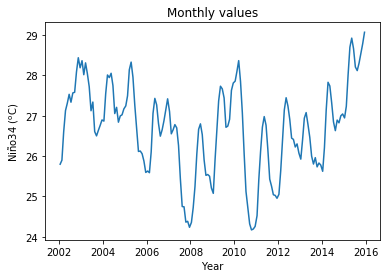

END


In [67]:
print('BEGIN.')

import math

rad = 4.0*math.atan(1.0)/180.0
#print('rad=',rad)

os.chdir(rundir)

grid_label='gr2'
grid_label='gn'
files_string='CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r1i1p2f1/Omon/'+dvar+'/'+grid_label+'/v20171025/'+dvar+'_Omon_historical_CAFE-1-0_r1i1p2f1_'+grid_label+'_??????-??????.nc'
files=glob.glob(files_string)

#print(files)

ifh0=netCDF4.Dataset(files[0])

time=ifh0.variables['time']
lat=ifh0.variables['latitude'][:,0]
lon=ifh0.variables['longitude'][0,:]

#print('lat=',lat[122:152])
#print('lon=',lon[110:160])

clat=np.cos(lat[:]*rad)
#print('clat=',clat)
#break

nino34_monthly=np.average(np.average(ifh0.variables['tos'][:,122:152,110:160],axis=1,weights=clat[122:152]),axis=1) #need to add in area weighting strictly

'''
print('time.units=',time.units)
print('time.calendar=',time.calendar)
print('time=',time)
print('time[:]=',time[:])
'''

date_time_stamp=netCDF4.num2date(time[:],time.units,time.calendar)

'''
print('date_time_stamp=',date_time_stamp)
num_stamp=netCDF4.date2num(date_time_stamp,time.units,time.calendar)
print('num_stamp=',num_stamp)
print('year_fraction=',year_fraction)
'''
year_fraction_monthly=fractional_year_from_num2date(date_time_stamp,time.calendar)

%matplotlib inline

plt.title('Monthly values')
plt.plot(year_fraction_monthly,nino34_monthly[:])
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()
print('END')

In the following monthly values will be calculated and then plotted.

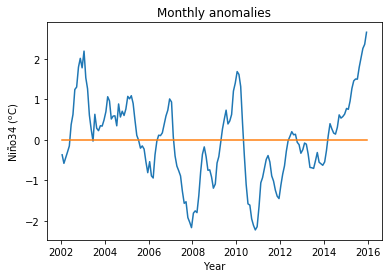

In [68]:
ybeg=date_time_stamp[0].year
yend=date_time_stamp[-1].year
ydiff=yend-ybeg+1
nmy=12

nino34_monthly_reshaped=np.reshape(nino34_monthly,new_monthly_array_shape(nino34_monthly.shape,ydiff,nmy))
climatology=np.average(nino34_monthly_reshaped,axis=0)
nino34_monthly_climatology=np.expand_dims(climatology,0)
nino34_monthly_climatology=np.tile(nino34_monthly_climatology,(ydiff,1))
nino34_monthly_climatology_flat=nino34_monthly_climatology.flatten()
nino34_monthly_anomaly=nino34_monthly-nino34_monthly_climatology_flat

%matplotlib inline

zero=np.zeros(len(year_fraction_monthly))
plt.plot(year_fraction_monthly,nino34_monthly_anomaly)
plt.plot(year_fraction_monthly,zero)

plt.title('Monthly anomalies')
plt.xlabel('Year')
plt.ylabel('Ni$\~{n}$o34 ($^o$C)')
plt.show()